In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import multiprocessing
from fastai.conv_learner import *
from fasterai.images import *
from fasterai.dataset import *
from fasterai.visualize import *
from pathlib import Path
from itertools import repeat
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True

/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
DATA_PATH = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
TRAIN_SOURCE_PATH = DATA_PATH/'train'
uid = 'bw2color'

In [4]:
sz = 128

In [5]:
TRAIN_X_PATH = generate_image_preprocess_path(TRAIN_SOURCE_PATH, is_x=True, size=sz, uid=uid)
TRAIN_Y_PATH = generate_image_preprocess_path(TRAIN_SOURCE_PATH, is_x=False, size=sz, uid=uid)

In [6]:
x_paths, y_paths = get_matched_xy_file_lists(TRAIN_X_PATH, TRAIN_Y_PATH)

In [7]:
x_paths_str = convert_paths_to_str(x_paths)
x_paths_str[:5]

['train_x_bw2color_128/n01440764/n01440764_10026.JPEG',
 'train_x_bw2color_128/n01440764/n01440764_10027.JPEG',
 'train_x_bw2color_128/n01440764/n01440764_10029.JPEG',
 'train_x_bw2color_128/n01440764/n01440764_10040.JPEG',
 'train_x_bw2color_128/n01440764/n01440764_10042.JPEG']

In [8]:
y_paths_str = convert_paths_to_str(y_paths)
y_paths_str[:5]

['train_y_bw2color_128/n01440764/n01440764_10026.JPEG',
 'train_y_bw2color_128/n01440764/n01440764_10027.JPEG',
 'train_y_bw2color_128/n01440764/n01440764_10029.JPEG',
 'train_y_bw2color_128/n01440764/n01440764_10040.JPEG',
 'train_y_bw2color_128/n01440764/n01440764_10042.JPEG']

In [9]:
bs = 64
np.random.seed(42)
#keep_pct = 1.
keep_pct = 0.02
keeps = np.random.rand(len(x_paths_str)) < keep_pct
fnames_x = np.array(x_paths_str, copy=False)[keeps]
fnames_y = np.array(y_paths_str, copy=False)[keeps]

In [10]:
arch = vgg16

In [11]:
aug_tfms = [RandomDihedral(tfm_y=TfmType.PIXEL)]

In [12]:
val_idxs = get_cv_idxs(len(fnames_x), val_pct=min(0.01/keep_pct, 0.1))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames_x), np.array(fnames_y))
len(val_x),len(trn_x)

(2558, 23026)

In [13]:
img_fn = TRAIN_Y_PATH/'n01558993'/'n01558993_9684.JPEG'

In [14]:
tfms = tfms_from_model(arch, sz, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms, sz_y=sz)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=TRAIN_Y_PATH.parent)
md = ImageData(DATA_PATH, datasets, bs, num_workers=16, classes=None)

In [15]:
denorm = md.val_ds.denorm

In [16]:
x,y = next(iter(md.val_dl))
x.size(),y.size()

(torch.Size([64, 3, 128, 128]), torch.Size([64, 3, 128, 128]))

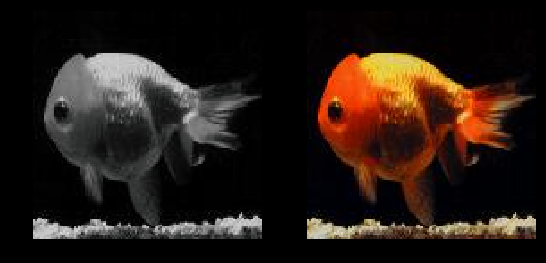

In [17]:
idx=1
fig,axes = plt.subplots(1, 2, figsize=(9,5))
plot_image_from_ndarray(denorm(x)[idx], axes=axes[0])
plot_image_from_ndarray(denorm(y)[idx], axes=axes[1])


In [18]:
def generate_denormed_image_pairs(ds: FilesDataset, batches: [(ndarray,ndarray)]):
    return [(ds.denorm(x)[idx], ds.denorm(y)[idx])for (x,y) in batches]

In [19]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

In [20]:
#image_pairs = [(denorm(x)[idx], denorm(y)[idx])for (x,y) in batches]
image_pairs = generate_denormed_image_pairs(md.val_ds, batches)

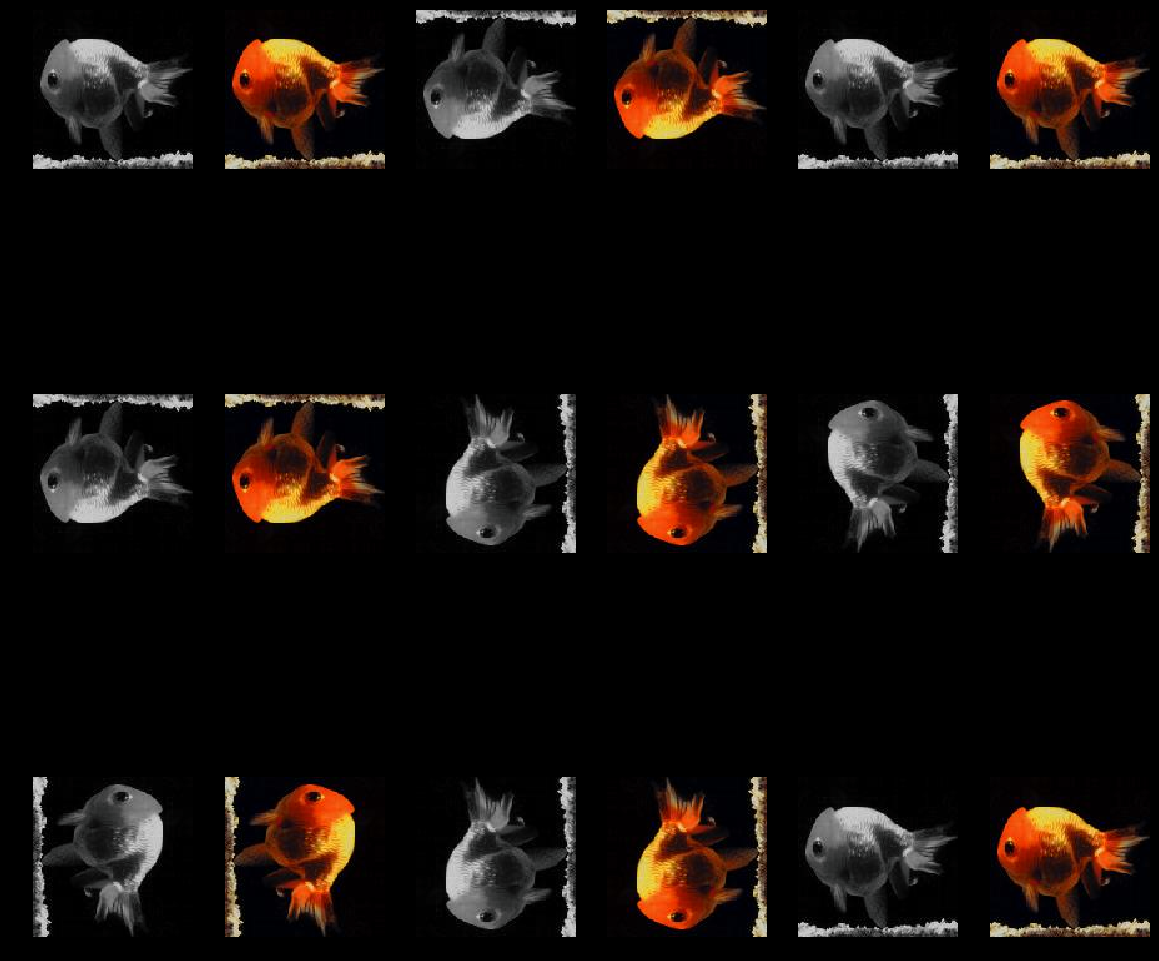

In [21]:
plot_images_from_ndarray_pairs(image_pairs)

## Model

##### TODO:  Try using unet instead of SrResnet- also suspect that using pretrained model as base will work much better.
##### TODO:  After making unet version- plug that into a Weiserman GAN setup (the discrimator looks at grey image and colorized image, concatenated together via channels).

In [22]:
def conv(ni, nf, kernel_size=3, actn=False):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

In [23]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x): 
        return x + self.m(x) * self.res_scale

In [24]:
def res_block(nf):
    return ResSequential([conv(nf, nf, actn=True), conv(nf, nf)], 0.1)

In [25]:
def upsample(ni, nf, scale):
    layers = []
    for i in range(int(math.log(scale,2))):
        layers += [conv(ni, nf*4), nn.PixelShuffle(2)]
    return nn.Sequential(*layers)

In [26]:
class SrResnet(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        features = [conv(3, 64)]
        for i in range(8): features.append(res_block(64))
        features += [conv(64,64), upsample(64, 64, scale),
                     nn.BatchNorm2d(64),
                     conv(64, 3)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): 
        return self.features(x)

## Perceptual loss

In [27]:
def icnr(x, scale=2, init=nn.init.kaiming_normal):
    new_shape = [int(x.shape[0] / (scale ** 2))] + list(x.shape[1:])
    subkernel = torch.zeros(new_shape)
    subkernel = init(subkernel)
    subkernel = subkernel.transpose(0, 1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0],
                                            subkernel.shape[1], -1)
    kernel = subkernel.repeat(1, 1, scale ** 2)
    transposed_shape = [x.shape[1]] + [x.shape[0]] + list(x.shape[2:])
    kernel = kernel.contiguous().view(transposed_shape)
    kernel = kernel.transpose(0, 1)
    return kernel

In [28]:
m_vgg = vgg16(True)

blocks = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
blocks, [m_vgg[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [29]:
vgg_layers = children(m_vgg)[:23]
m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
set_trainable(m_vgg, False)

In [30]:
m_vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

In [31]:
def flatten(x): return x.view(x.size(0), -1)

In [32]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()        

In [33]:
class FeatureLoss(nn.Module):
    def __init__(self, m, layer_ids, layer_wgts):
        super().__init__()
        self.m,self.wgts = m,layer_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]

    def forward(self, input, target, sum_layers=True):
        self.m(VV(target.data))
        res = [F.l1_loss(input,target)/100]
        targ_feat = [V(o.features.data.clone()) for o in self.sfs]
        self.m(input)
        res += [F.l1_loss(flatten(inp.features),flatten(targ))*wgt
               for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

In [34]:
m = SrResnet(64, 1)

In [35]:
m.features

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (1): ResSequential(
    (m): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (2): ResSequential(
    (m): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (3): ResSequential(
    (m): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
 

In [36]:
m = to_gpu(m)

In [37]:
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

In [38]:
m = nn.DataParallel(m, [0,1])
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

In [39]:
learn.set_data(md)

In [40]:
learn.crit = FeatureLoss(m_vgg, blocks[:3], [0.2,0.7,0.1]) #(turns sepia)
#learn.crit = F.mse_loss #(turns sepia)
#learn.crit = F.l1_loss (turns it into a totally blank sepia image!)
#learn.crit =  FeatureLoss(m_vgg, blocks[:3], [0.9,0.05,0.05])

In [41]:
wd=1e-7

In [42]:
learn.lr_find(1e-4, 0.1, wds=wd, linear=False)

 71%|███████   | 254/360 [01:57<00:48,  2.17it/s, loss=0.0977]

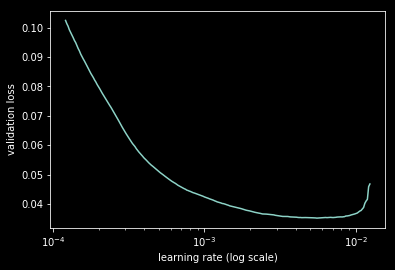

In [43]:
learn.sched.plot(n_skip_end=1)

In [44]:
lr=1e-3

In [ ]:
learn.fit(lr, 1, cycle_len=2, wds=wd, use_clr_beta=(20,10,0.95,0.85))

In [ ]:
learn.save('bwtoc0')

In [45]:
learn.load('bwtoc0')

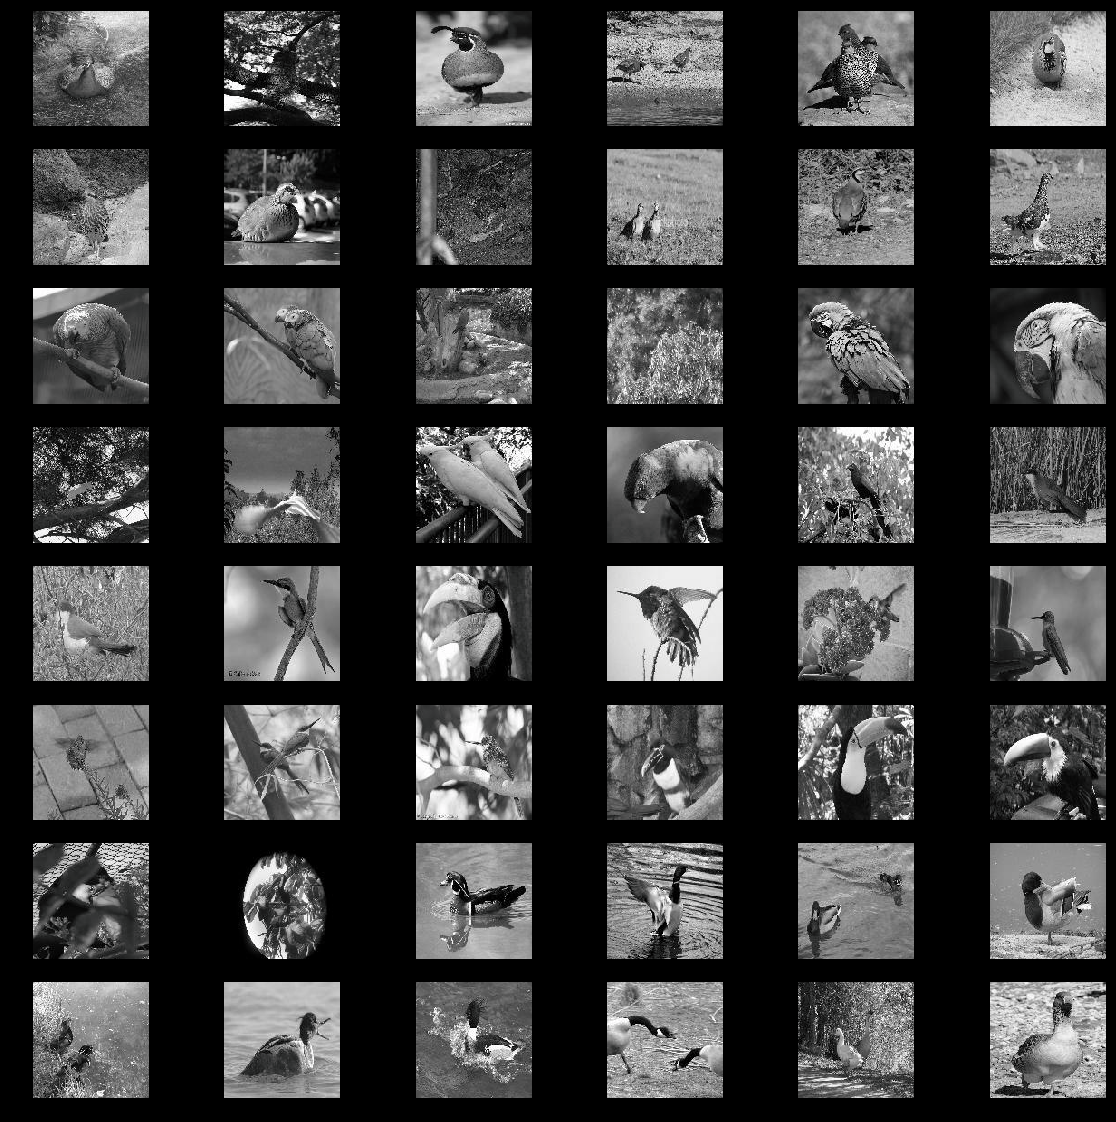

In [46]:
plot_images_from_dataset(md.val_ds, 200, 48)

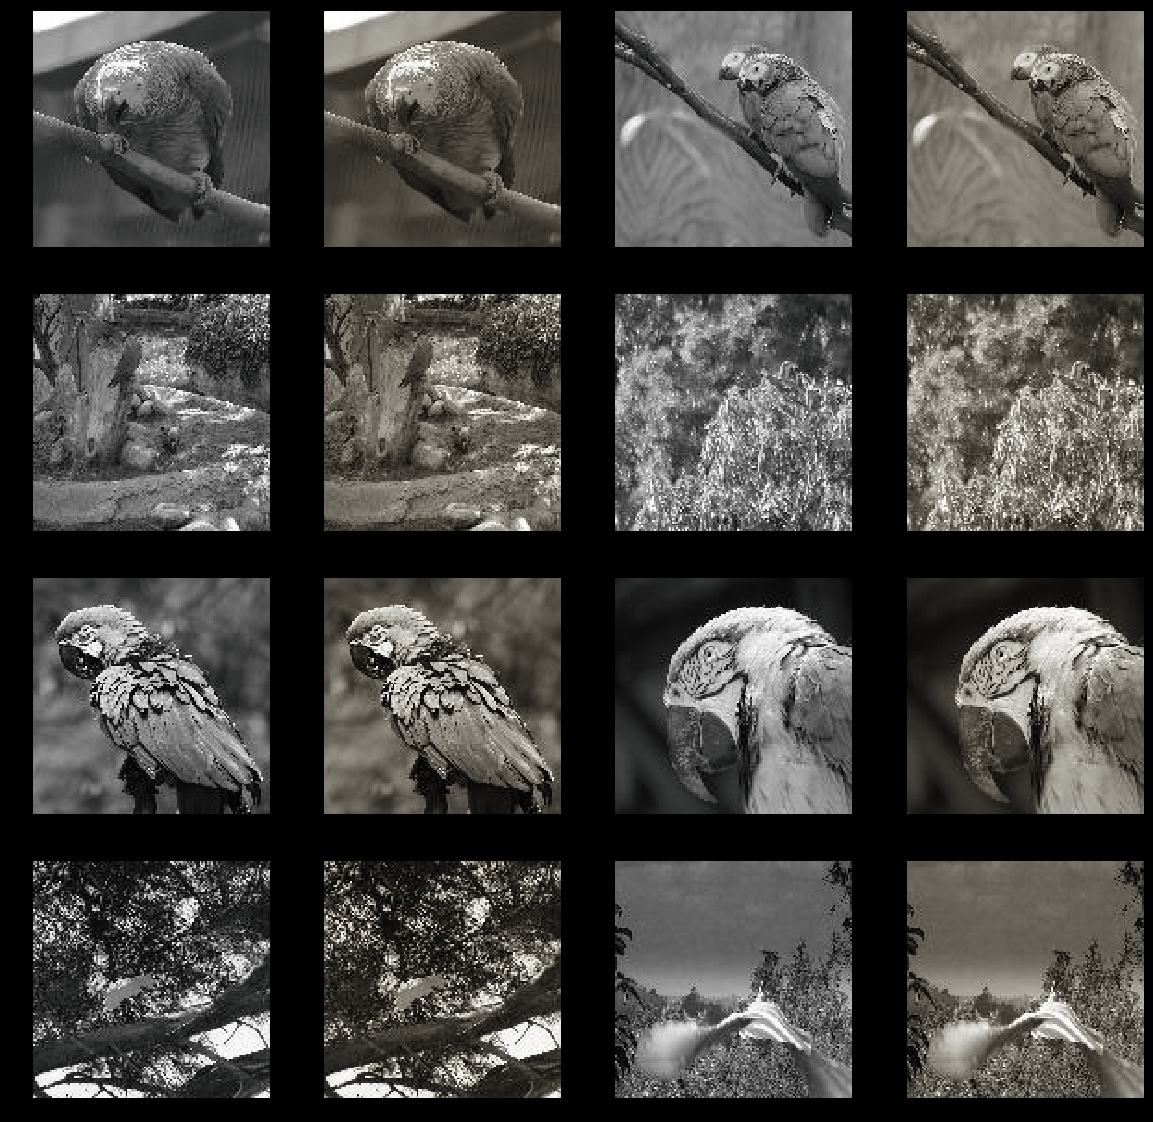

In [54]:
start_idx = 212
end_index = start_idx + 8
plot_image_outputs_from_model(md.val_ds, learn.model, list(range(start_idx,end_index)), figsize=(20,20), max_columns=4)

In [ ]:
learn.load('bwtoc0')

In [ ]:
lr=lr/2

In [ ]:
learn.fit(lr/3, 1, cycle_len=1, wds=wd, use_clr_beta=(20,10,0.95,0.85))

In [ ]:
learn.save('bwtoc2')

In [ ]:
learn.load('bwtoc2')

In [ ]:
learn.sched.plot_loss()

In [ ]:
fig,axes=plt.subplots(6,6,figsize=(20,20))
for i,ax in enumerate(axes.flat): plot_ds_img(i+200,ax=ax, normed=True)

In [ ]:
x,y=md.val_ds[211]

In [ ]:
y=y[None]

In [ ]:
learn.model.eval()
preds = learn.model(VV(x[None]))
x.shape,y.shape,preds.shape

In [ ]:
#learn.crit(preds, V(y), sum_layers=False)

In [ ]:
_,axes=plt.subplots(1,2,figsize=(14,7))
show_img(x[None], 0, ax=axes[0])
show_img(preds,0, normed=True, ax=axes[1])

In [ ]:
bs = 32
sz = 256

In [ ]:
t = torch.load(learn.get_model_path('bwtoc2'), map_location=lambda storage, loc: storage)
learn.model.load_state_dict(t, strict=False)

In [ ]:
learn.freeze_to(999)

In [ ]:
for i in range(10,13): set_trainable(learn.model.module.features[i], True)

In [ ]:
conv_shuffle = learn.model.module.features[10][2][0]
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel);

In [ ]:
lr=6e-3
wd=1e-7

In [ ]:
learn.fit(lr, 1, cycle_len=2, wds=wd, use_clr_beta=(20,10,0.95,0.85))

In [ ]:
learn.save('bwtoc3')

In [ ]:
learn.load('bwtoc3')

In [ ]:
learn.fit(lr/2, 1, cycle_len=2, wds=wd, use_clr_beta=(20,10,0.95,0.85))

In [ ]:
learn.save('bwtoc4')

In [ ]:
learn.load('bwtoc4')

In [ ]:
learn.fit(lr/6, 1, cycle_len=1, wds=wd, use_clr=(20,10))

In [ ]:
learn.save('bwtoc5')

In [ ]:
learn.load('bwtoc5')